In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os


from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image
from tempfile import TemporaryDirectory
from caesar.logger.logger import setup_logger

logger = setup_logger(__name__)
cudnn.benchmark = True
plt.ion()

# Load Data

In [3]:
import torch.utils
import torch.utils.data


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = "../data/hymenoptera_data"

image_datasets = {x: datasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_size = {x: len(image_datasets[x])for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device {device}")

[2025-05-13 15:46:43.480234 INFO   ] 2650663419:<module>:31 - Using device cuda


# Visualize a few images

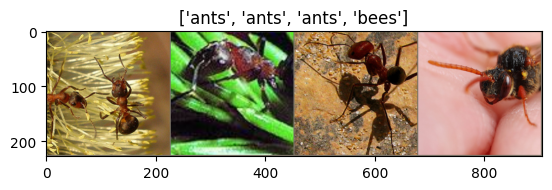

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp+mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Training model

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            logger.info(f"Epoch {epoch}/{num_epochs-1}")
            logger.info("-"*10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item()*inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss/dataset_size[phase]
                epoch_acc = running_corrects.double()/dataset_size[phase]

                logger.info(
                    f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            logger.info("")

        time_elapsed = time.time()-since
        logger.info(
            f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        logger.info(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(
            best_model_params_path, weights_only=True))
    return model

# Visualizing the model predictions

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels=labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the ConvNet

In [13]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device=device)
criterion = nn.CrossEntropyLoss()
optimize_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimize_ft, step_size=7, gamma=0.1)

# Train and evaluate 

In [14]:
model_ft = train_model(model_ft, criterion, optimize_ft,
                       exp_lr_scheduler, num_epochs=25)

[2025-05-13 15:49:15.137770 INFO   ] 3974243127:train_model:9 - Epoch 0/24
[2025-05-13 15:49:15.138771 INFO   ] 3974243127:train_model:10 - ----------
[2025-05-13 15:49:19.576647 INFO   ] 3974243127:train_model:44 - train Loss: 0.6096 Acc: 0.7254
[2025-05-13 15:49:23.777311 INFO   ] 3974243127:train_model:44 - val Loss: 0.2747 Acc: 0.9020
[2025-05-13 15:49:23.828311 INFO   ] 3974243127:train_model:50 - 
[2025-05-13 15:49:23.829322 INFO   ] 3974243127:train_model:9 - Epoch 1/24
[2025-05-13 15:49:23.829322 INFO   ] 3974243127:train_model:10 - ----------
[2025-05-13 15:49:28.169589 INFO   ] 3974243127:train_model:44 - train Loss: 0.5045 Acc: 0.7910
[2025-05-13 15:49:31.867173 INFO   ] 3974243127:train_model:44 - val Loss: 0.3305 Acc: 0.8824
[2025-05-13 15:49:31.869174 INFO   ] 3974243127:train_model:50 - 
[2025-05-13 15:49:31.870173 INFO   ] 3974243127:train_model:9 - Epoch 2/24
[2025-05-13 15:49:31.870173 INFO   ] 3974243127:train_model:10 - ----------
[2025-05-13 15:49:36.295212 INFO   

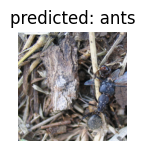

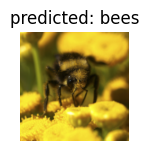

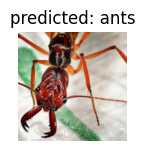

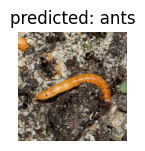

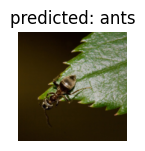

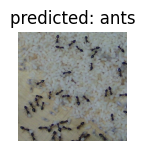

In [17]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [18]:
model_conv=torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad=False

num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)

model_conv=model_conv.to(device)
criterion=nn.CrossEntropyLoss()

optimizer_conv=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler=lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)


# Train and evaluate  

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

[2025-05-13 15:57:50.586813 INFO   ] 3974243127:train_model:9 - Epoch 0/24
[2025-05-13 15:57:50.587814 INFO   ] 3974243127:train_model:10 - ----------
[2025-05-13 15:57:55.087846 INFO   ] 3974243127:train_model:44 - train Loss: 0.6694 Acc: 0.6475
[2025-05-13 15:57:59.416052 INFO   ] 3974243127:train_model:44 - val Loss: 0.2635 Acc: 0.8824
[2025-05-13 15:57:59.465052 INFO   ] 3974243127:train_model:50 - 
[2025-05-13 15:57:59.465052 INFO   ] 3974243127:train_model:9 - Epoch 1/24
[2025-05-13 15:57:59.466072 INFO   ] 3974243127:train_model:10 - ----------
[2025-05-13 15:58:03.791812 INFO   ] 3974243127:train_model:44 - train Loss: 0.3898 Acc: 0.8197
[2025-05-13 15:58:07.875548 INFO   ] 3974243127:train_model:44 - val Loss: 0.1953 Acc: 0.9216
[2025-05-13 15:58:07.918555 INFO   ] 3974243127:train_model:50 - 
[2025-05-13 15:58:07.919555 INFO   ] 3974243127:train_model:9 - Epoch 2/24
[2025-05-13 15:58:07.919555 INFO   ] 3974243127:train_model:10 - ----------
[2025-05-13 15:58:12.569651 INFO   

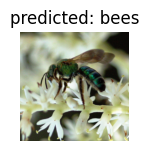

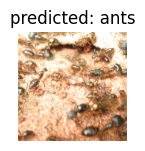

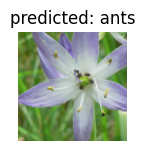

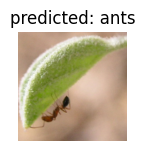

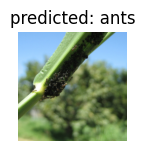

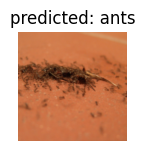

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Inference on custom images

In [21]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

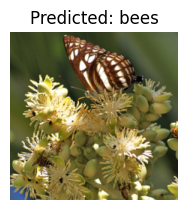

In [22]:
visualize_model_predictions(
    model_conv, img_path='../data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg')

plt.ioff()
plt.show()